In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option('mode.chained_assignment', None)

In [2]:
data = pd.read_csv("data/Goblin_SingleQLAI_Goblin2(3).csv")
print("Num rows: ", len(data))
print("Cols: ", data.keys())
data.head()

Num rows:  32996
Cols:  Index(['pos_x_diff', 'pos_y_diff', 'enemy_dist', 'self_life', 'enemy_life',
       'enemy_attacking', 'enemy_dir_x', 'enemy_dir_y', 'q_val', 'reward',
       'next_val', 'priority', 'epsilon', 'experience_size', 'time', 'exp_id',
       'replay', 'terminal', 'idle_q', 'attack_q', 'walk_right_q',
       'walk_up_right_q', 'walk_up_q', 'walk_up_left_q', 'walk_left_q',
       'walk_down_left_q', 'walk_down_q', 'walk_down_right_q'],
      dtype='object')


pos_x_diff  pos_y_diff  enemy_dist  self_life  enemy_life  enemy_attacking  \
0   -0.036177   -0.082681    0.090249        1.0         1.0             -1.0   
1   -0.036177   -0.082681    0.090249        1.0         1.0             -1.0   
2   -0.034209   -0.087431    0.093885        1.0         1.0             -1.0   
3   -0.017991   -0.077931    0.079981        1.0         1.0             -1.0   
4   -0.027491   -0.068431    0.073747        1.0         1.0             -1.0   

    enemy_dir_x  enemy_dir_y     q_val  reward  ...    idle_q  attack_q  \
0  3.139160e-07          1.0  0.421932     0.0  ...  0.421932  0.421932   
1  3.139160e-07          1.0  0.421932     0.0  ...  0.168643  0.168643   
2 -4.371100e-08         -1.0  0.168643     0.0  ... -0.114462 -0.114462   
3  1.000000e+00          0.0 -0.114462     0.0  ... -0.115936 -0.115936   
4  1.000000e+00          0.0 -0.115936     0.0  ...  0.407986  0.407986   

   walk_right_q  walk_up_right_q  walk_up_q  walk_up_left_q  walk_left_q  \
0      0.422150         0.421770   0.421484        0.421460     0.421712   
1      0.168874         0.168506   0.168218        0.168180     0.168412   
2     -0.114176        -0.114552  -0.114875       -0.114957    -0.114748   
3     -0.115656        -0.116031  -0.116350       -0.116427    -0.116216   
4      0.408181         0.407800   0.407528        0.407524     0.407791   

   walk_down_left_q  walk_down_q  walk_down_right_q  
0          0.422093     0.422379           0.422403  
1          0.168780     0.169068           0.169106  
2         -0.114372    -0.114048          -0.113967  
3         -0.115842    -0.115522          -0.115446  
4          0.408172     0.408444           0.408448  

[5 rows x 28 columns]

In [3]:
eps = 1e-6

def get_reward_bin(reward):
    third = 1.0 / 3.0
    half = 1.0 / 2.0
    reward_table = {
        - 1.0: "(dead, -)",
        - half: "(2 -> 1, 0)",
        - third: "(3 -> 2, 0)",
        third - half: "(2 -> 1, 3 -> 2)",
        0.0: "(-, -)",
        half - third: "(3 -> 2, 2 -> 1)",
        third: "(0, 3 -> 2)",
        half: "(2 -> 1, 0)",
        1.0: "(-, dead)"
    }
    for k, v in reward_table.items():
        if reward <= k + eps and reward >= k - eps:
            return v
    if abs(reward) <= third + eps:
        return "medium"
    if reward > third:
        return "high"
    return "low"

discount = 0.999

q_vals = data.filter(regex="_q$")
data["q_avg"] = q_vals.mean(axis=1)
data["q_std"] = q_vals.std(axis=1)

data["label"] = data["reward"] + discount * data["next_val"] * (~ data["terminal"])
data["loss"] = (data["label"] - data["q_val"])**2
data["reward_bin"] = data["reward"].map(get_reward_bin)

replay_data = data[data["replay"] == True]
real_time_data = data[data["replay"] == False]

replay_times = sorted(replay_data["time"].value_counts().keys().tolist())
max_time = max(data["time"]) + 0.1

print("Max time: ", max_time)
print()
print(data["replay"].value_counts())
print()
print(data[["q_avg", "q_std"]].head())
print()
print(data.describe())

Max time:  599.700000000068

True     27000
False     5996
Name: replay, dtype: int64

      q_avg     q_std
0  0.421931  0.000332
1  0.168643  0.000322
2 -0.114462  0.000335
3 -0.115936  0.000333
4  0.407986  0.000332

         pos_x_diff    pos_y_diff    enemy_dist     self_life    enemy_life  \
count  32996.000000  32996.000000  32996.000000  32996.000000  32996.000000   
mean      -0.007638     -0.032308      0.086485      0.839264      0.930456   
std        0.062546      0.063050      0.038853      0.227607      0.144398   
min       -0.158953     -0.163835      0.009174      0.000000      0.333333   
25%       -0.053831     -0.079188      0.057073      0.666667      1.000000   
50%       -0.009858     -0.036261      0.081618      1.000000      1.000000   
75%        0.036738      0.010464      0.111812      1.000000      1.000000   
max        0.158653      0.159673      0.219752      1.000000      1.000000   

       enemy_attacking   enemy_dir_x   enemy_dir_y         q_val  \


In [4]:
def plot_replay_lines(df, y_var):
    max_val = max(df[y_var])
    min_val = min(df[y_var])
    lines = []
    for time in replay_times:
        lines.append([time, time])
        lines.append([min_val, max_val])
    plt.plot(*lines, linestyle=":", color="green")
    
def separate_outliers(df, var, c=1.5):
    quantiles = df[var].quantile([0.25, 0.75])
    iq_height = quantiles[0.75] - quantiles[0.25]
    outliers_range = [quantiles[0.25] - c * iq_height, quantiles[0.75] + c * iq_height]
    outliers = df[(df[var] < outliers_range[0]) | (df[var] > outliers_range[1])]
    not_outliers = df[(df[var] >= outliers_range[0]) & (df[var] <= outliers_range[1])]
    return not_outliers, outliers

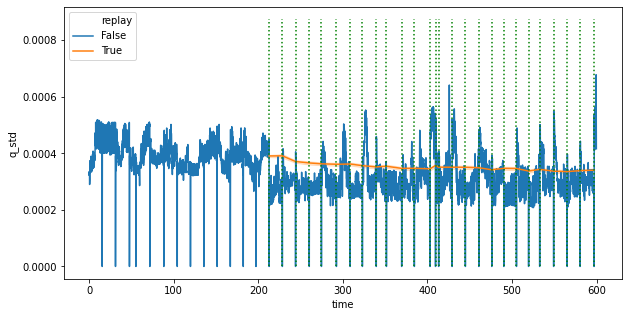

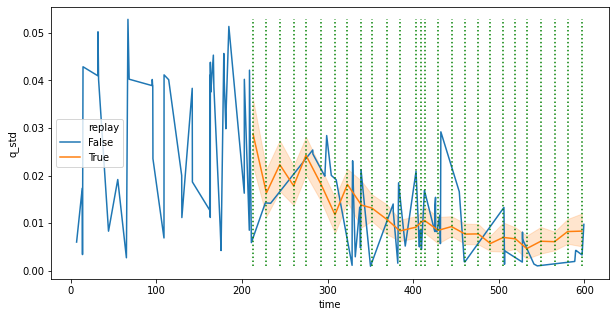

In [5]:
time_q_std = data[["time", "q_std", "replay"]]
c = 4.0

not_outliers, outliers = separate_outliers(time_q_std, "q_std", c=c)

plt.figure(figsize=(10, 5))
sns.lineplot(x="time", y="q_std", hue="replay", data=not_outliers)
plot_replay_lines(not_outliers, "q_std")
plt.show()

plt.figure(figsize=(10, 5))
sns.lineplot(x="time", y="q_std", hue="replay", data=outliers)
plot_replay_lines(outliers, "q_std")
plt.show()

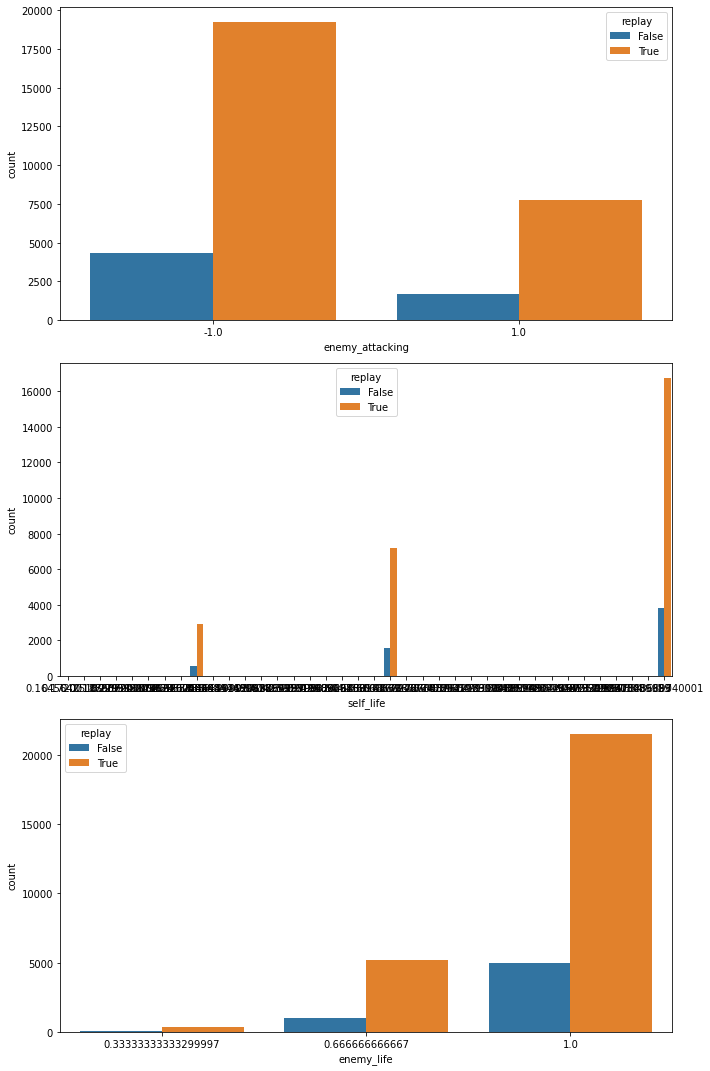

In [6]:
rows = ['enemy_attacking', 'self_life', 'enemy_life']

fig, ax = plt.subplots(len(rows), 1, figsize=(10, 15))
for i in range(len(rows)):
    sns.countplot(x=rows[i], hue="replay", data=data, ax=ax[i])
plt.tight_layout()
plt.show()

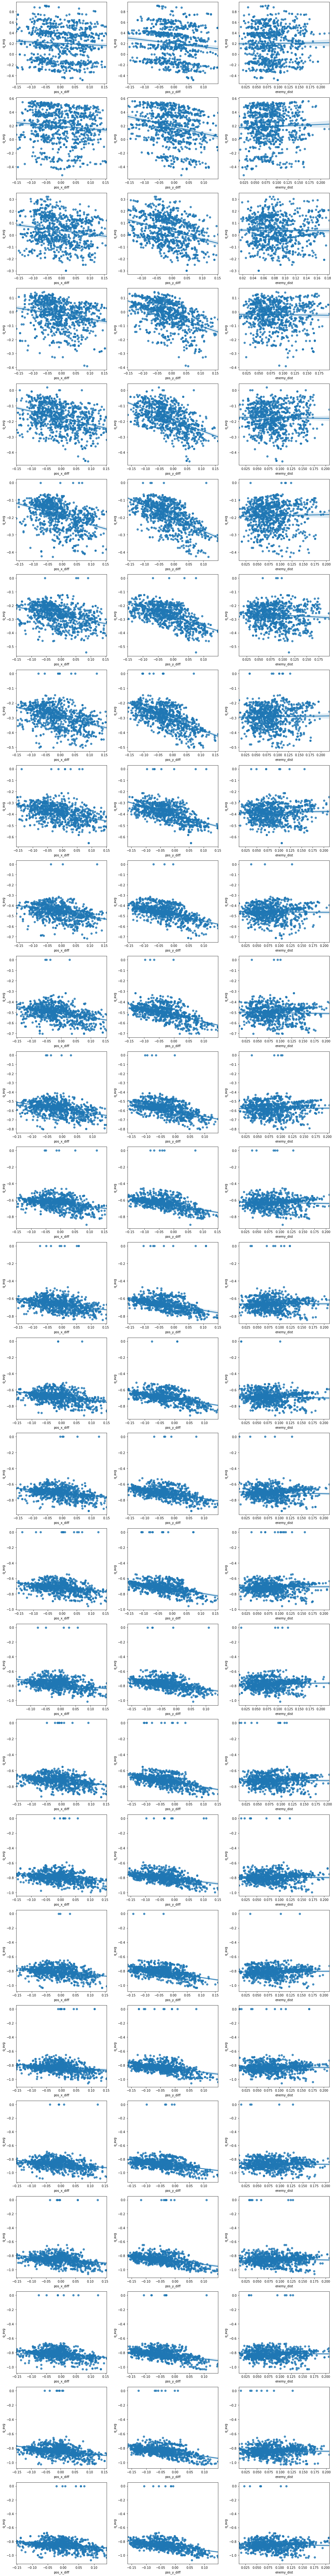

In [7]:
cols = ['pos_x_diff', 'pos_y_diff', 'enemy_dist']

fig, ax = plt.subplots(len(replay_times), len(cols), figsize=(15, 4.25 * len(replay_times)))
for i in range(len(replay_times)):
    time_data = replay_data[replay_data["time"] == replay_times[i]]
    for j in range(len(cols)):
        sns.regplot(x=cols[j], y="q_avg", data=time_data, ax=ax[i][j])
plt.tight_layout()
plt.show()

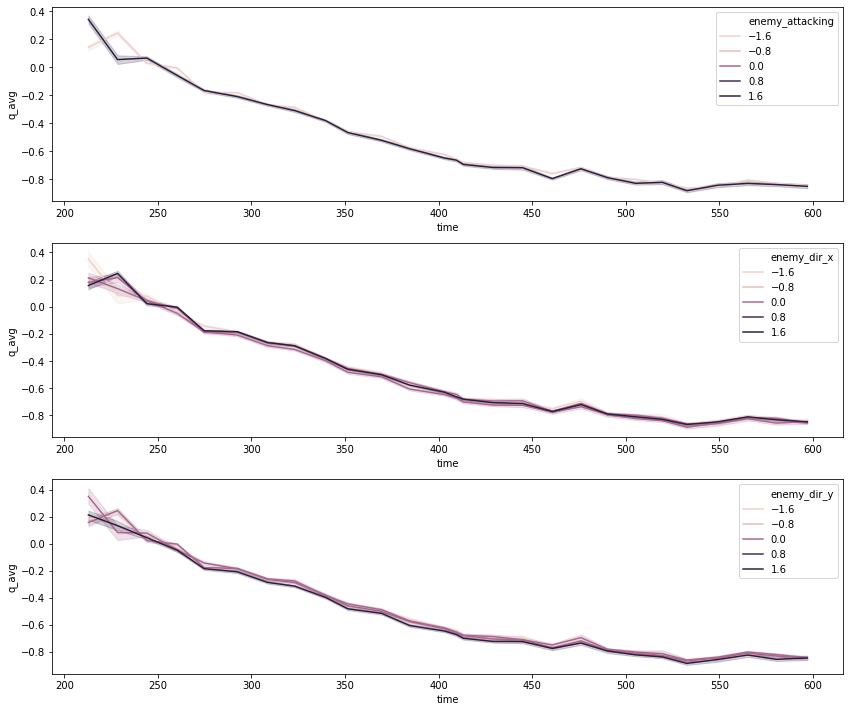

In [8]:
rows = ['enemy_attacking', 'enemy_dir_x', 'enemy_dir_y']

fig, ax = plt.subplots(len(rows), 1, figsize=(12, 10))
for i in range(len(rows)):
    sns.lineplot(x="time", y="q_avg", hue=rows[i], data=replay_data, ax=ax[i])
plt.tight_layout()
plt.show()

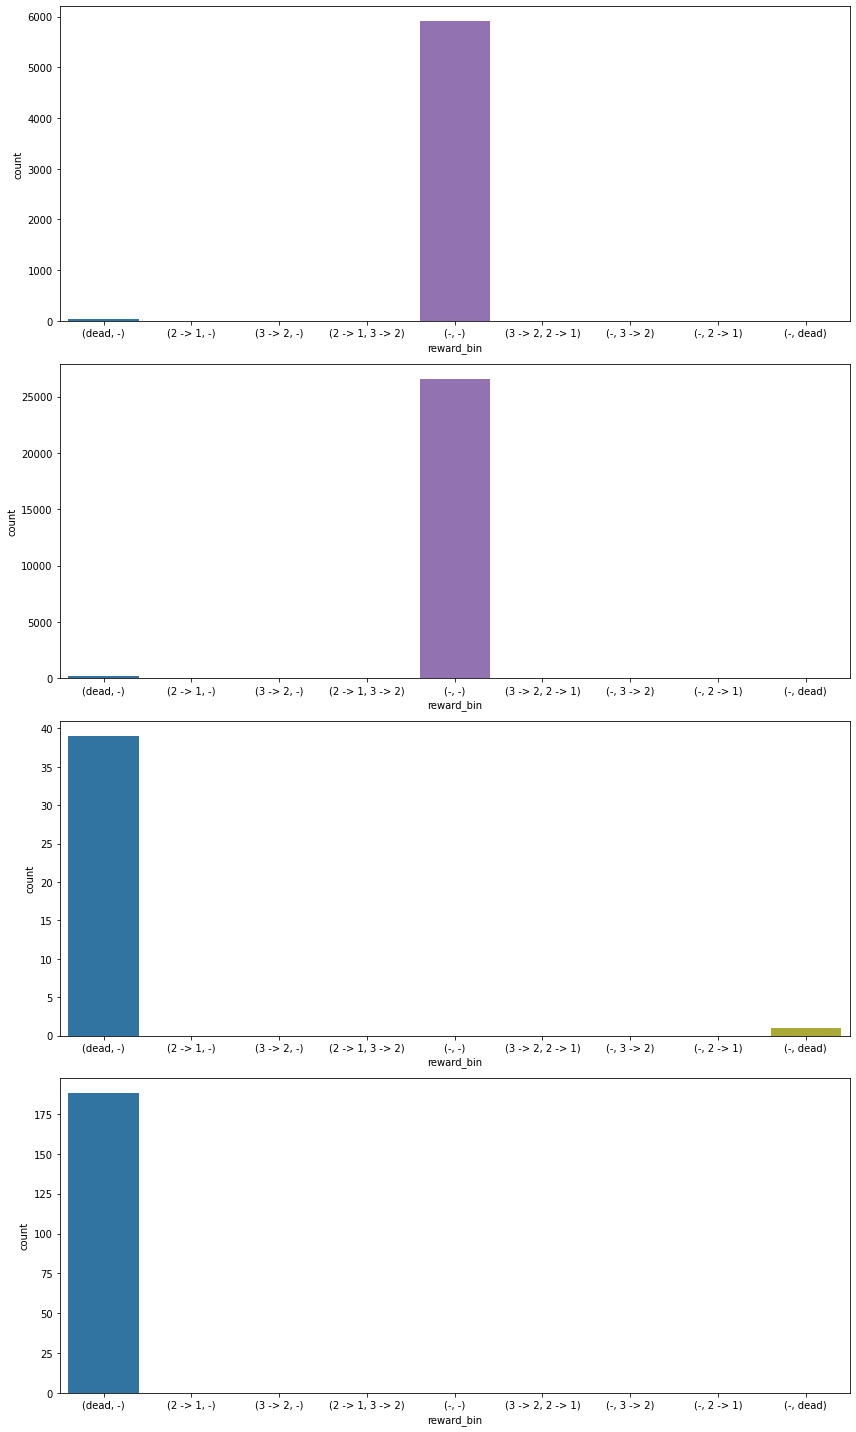

In [15]:
order = ["(dead, -)", "(2 -> 1, -)", "(3 -> 2, -)", "(2 -> 1, 3 -> 2)", "(-, -)", "(3 -> 2, 2 -> 1)", "(-, 3 -> 2)", "(-, 2 -> 1)", "(-, dead)"]
fig, ax = plt.subplots(4, 1, figsize=(12, 20))
sns.countplot(x="reward_bin", data=real_time_data, order=order, ax=ax[0])
sns.countplot(x="reward_bin", data=replay_data, order=order, ax=ax[1])
sns.countplot(x="reward_bin", data=real_time_data[real_time_data["reward_bin"] != "(-, -)"], order=order, ax=ax[2])
sns.countplot(x="reward_bin", data=replay_data[replay_data["reward_bin"] != "(-, -)"], order=order, ax=ax[3])
plt.tight_layout()
plt.show()

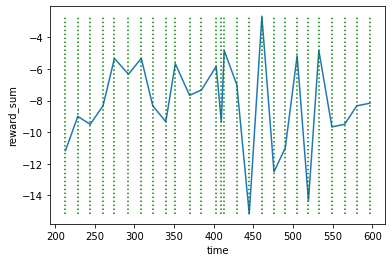

In [10]:
# Group rewards by time and accumulate them
reward_time = replay_data.groupby(by="time")["reward"].sum().to_frame("reward_sum").reset_index()
# Plot the graph
sns.lineplot(x="time", y="reward_sum", data=reward_time)

plot_replay_lines(reward_time, "reward_sum")
plt.show()

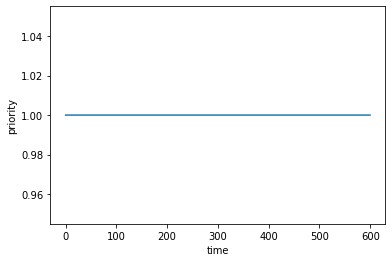

In [11]:
sns.lineplot(x="time", y="priority", data=real_time_data)

plot_replay_lines(real_time_data, "priority")
plt.show()

In [12]:
terminal_priority = data[["terminal", "priority"]]
print(terminal_priority[terminal_priority["terminal"] == False].describe())
print(terminal_priority[terminal_priority["terminal"] == True].describe())

       priority
count   32768.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
       priority
count     228.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0


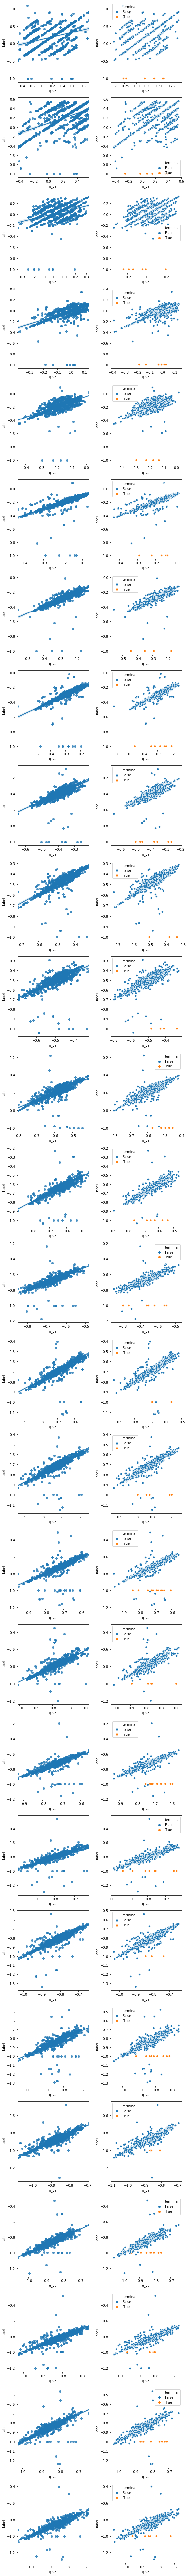

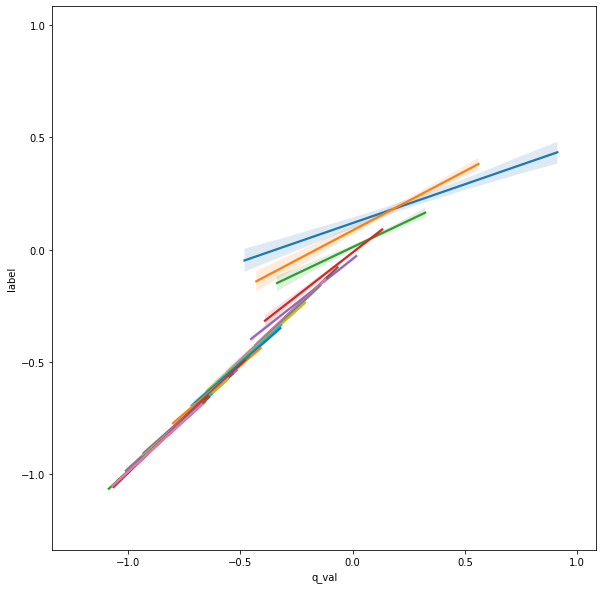

In [13]:
# Relation between q_val and label through time
fig, ax = plt.subplots(len(replay_times), 2, figsize=(8, 4 * len(replay_times)))
for i in range(len(replay_times)):
    this_time_data = replay_data[replay_data["time"] == replay_times[i]]
    sns.regplot(x="q_val", y="label", data=this_time_data, ax=ax[i][0])
    sns.scatterplot(x="q_val", y="label", hue="terminal", data=this_time_data, ax=ax[i][1])
plt.tight_layout()
plt.show()

axis_max = max([max(replay_data["label"]), max(replay_data["q_val"])])
axis_min = min([min(replay_data["label"]), min(replay_data["q_val"])])

# Regression lines plotted side by side
plt.figure(figsize=(10, 10))
for i in range(len(replay_times)):
    sns.regplot(x="q_val", y="label", data=replay_data[replay_data["time"] == replay_times[i]], scatter=False)
plt.xlim(axis_min, axis_max)
plt.ylim(axis_min, axis_max)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
# Primeira linha é a azul escura

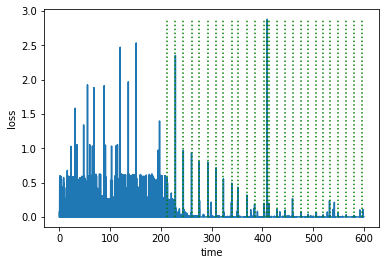

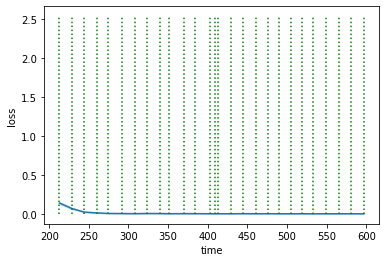

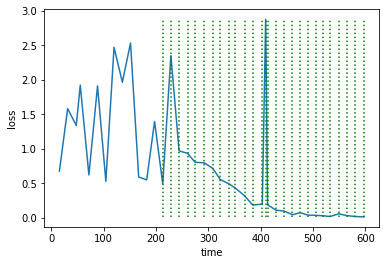

In [14]:
sns.lineplot(x="time", y="loss", data=real_time_data)
plot_replay_lines(real_time_data, "loss")
plt.show()

sns.lineplot(x="time", y="loss", data=replay_data)
plot_replay_lines(replay_data, "loss")
plt.show()

terminal_data = real_time_data[real_time_data["terminal"] == True]
sns.lineplot(x="time", y="loss", data=terminal_data)
plot_replay_lines(terminal_data, "loss")
plt.show()